<a href="https://colab.research.google.com/github/CD-AC/DataEnginner-Gas_Station_Geolocation/blob/main/Gas_Station_Geolocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

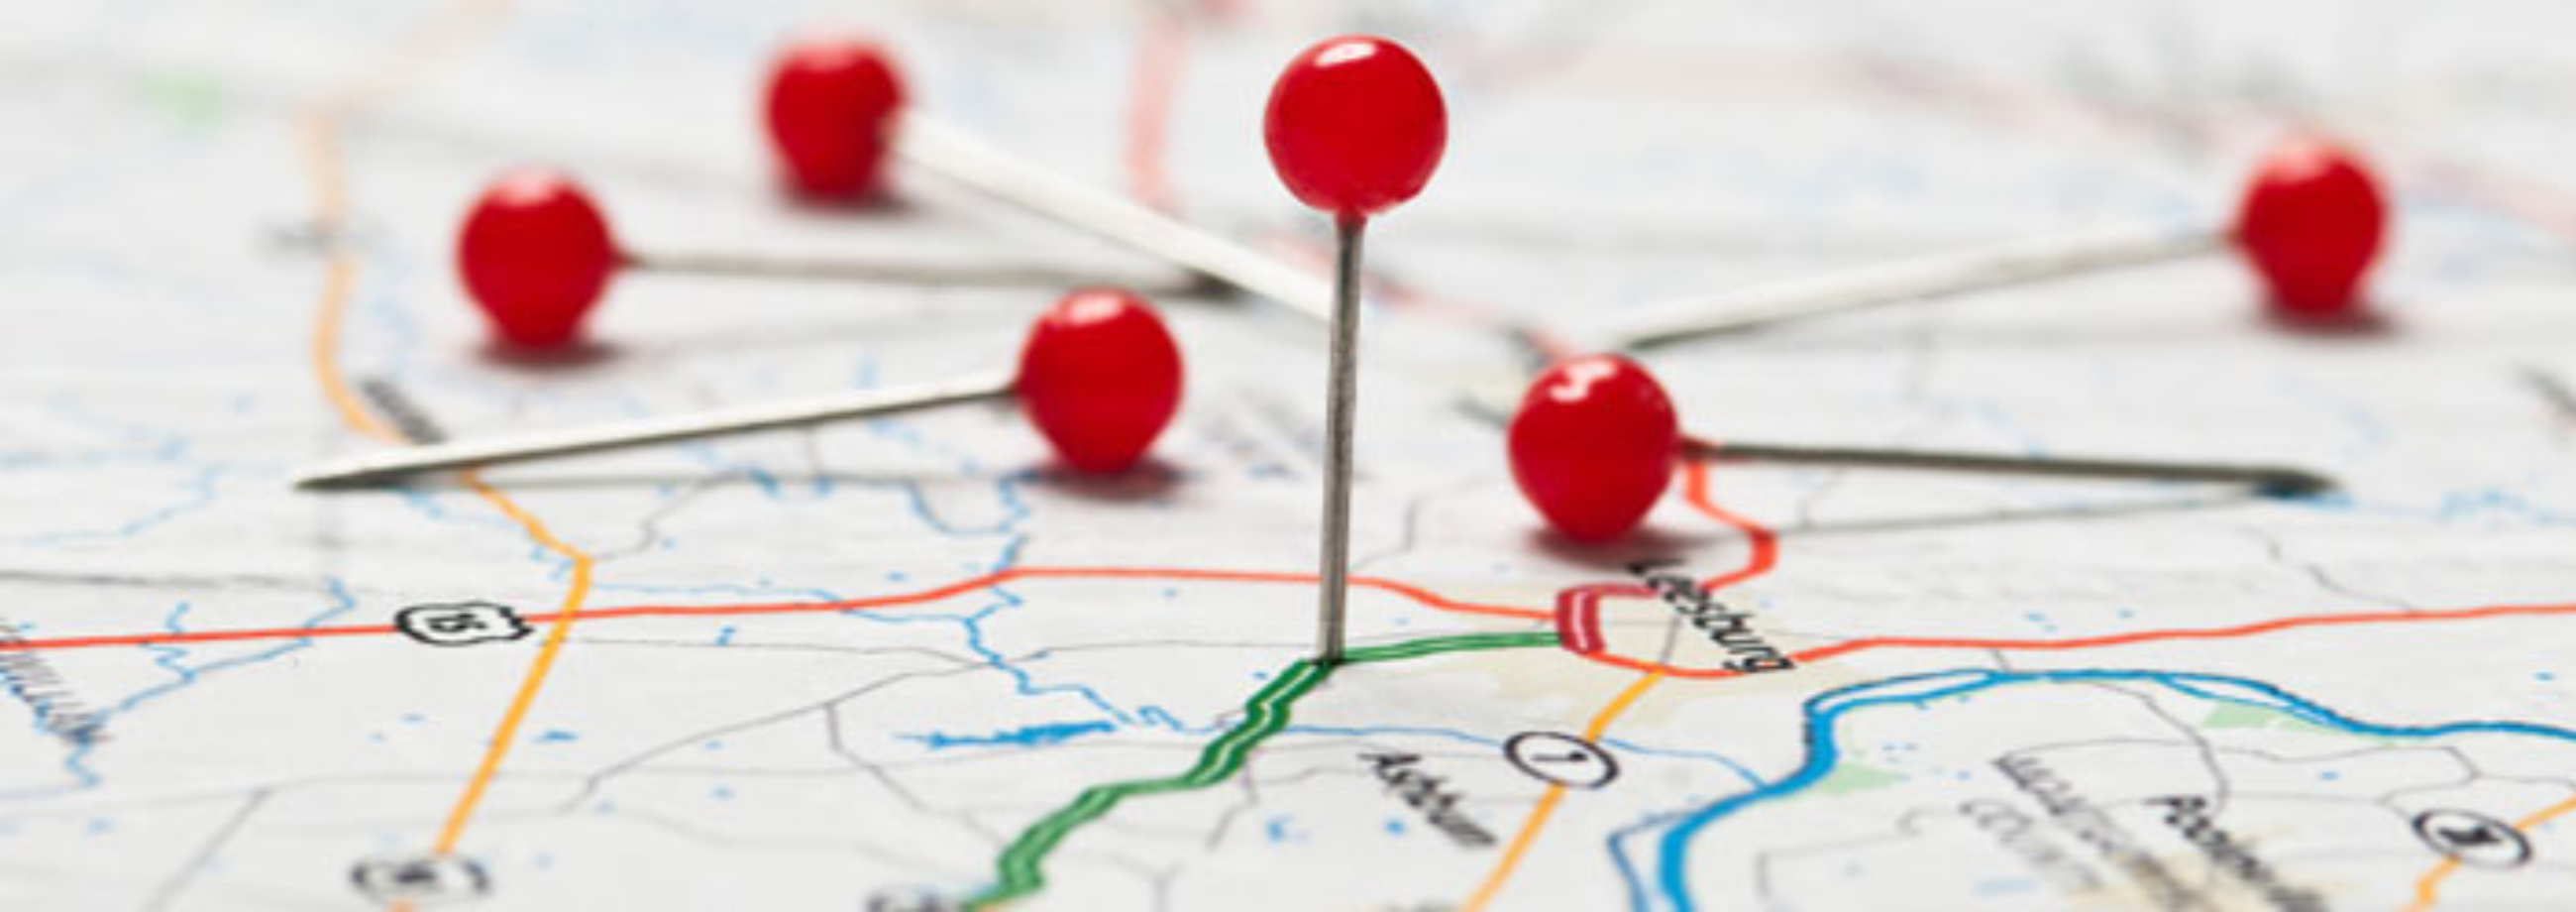

In [ ]:
!pip install haversine
!pip install shapely
!pip install geopandas
!pip install geojson
!pip install folium
!pip install tqdm

# Import Dependencies

In [ ]:
import requests
import random
import pandas as pd
from tqdm import tqdm
from cred_here import YOUR_API_KEY
import json

import ast
import folium
from shapely.geometry import Polygon
import numpy as np
import geojson
import folium
import matplotlib.pyplot as plt
import geopandas as gpd
from tqdm import tqdm
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import shapely.wkt
from haversine import haversine, Unit
import random
import time
from pyproj import Geod

from shapely import wkt
from geopandas import datasets, GeoDataFrame, read_file, points_from_xy
from geopandas.tools import overlay
from geopandas.tools import sjoin

from folium.plugins import MeasureControl
from folium.plugins import MarkerCluster

from tqdm import tqdm
import json

import requests
import random
import time

# Read Dataset Final

In [ ]:
df_map = pd.read_csv('DATASET_FINAL.CSV')

In [ ]:
df_map.head(2)

,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado,Dir2,Full_Address,Coords
0,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,GASOLINA CORRIENTE OXIGENADA,9860,A,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.6992158, -74.028637)"
1,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,BIODIESEL EXTRA,9780,A,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.6992158, -74.028637)"


In [ ]:
df_map = df_map.drop_duplicates(subset=['Nombre_comercial','Bandera','Producto'])

In [ ]:
len(df_map)

611

In [ ]:
df_map['Coords'].value_counts()

('NA', 'NA')                18
(4.7109886, -74.072092)      5
(4.5803705, -74.1509316)     5
(4.5187508, -74.1221477)     5
(4.686463, -74.095867)       4
                            ..
(4.6529299, -74.1166488)     1
(4.508056, -74.1140039)      1
(4.7091229, -74.1120729)     1
(4.6207381, -74.1852713)     1
(4.5964216, -74.1538619)     1
Name: Coords, Length: 230, dtype: int64

In [ ]:
df_map[df_map['Coords']=="('NA', 'NA')"]['Direccion'].unique()

array(['Avenida Carrera 30 # 2 - 38', 'CRA 17 # 50-42',
       'CALLE 80 # 24-30', 'Carrera 73 # 36A - 55 Sur',
       'Calle 13 # 38 - 25', 'Calle 19 # 33 - 68', 'Carrera 7 # 84 - 91'],
      dtype=object)

In [ ]:
df_map.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611 entries, 0 to 856
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Periodo              611 non-null    int64 
 1   Mes                  611 non-null    int64 
 2   Codigo_departamento  611 non-null    int64 
 3   Departamento         611 non-null    object
 4   Codigo_municipio     611 non-null    int64 
 5   Municipio            611 non-null    object
 6   Nombre_comercial     611 non-null    object
 7   Bandera              611 non-null    object
 8   Direccion            611 non-null    object
 9   Producto             611 non-null    object
 10  Precio               611 non-null    int64 
 11  Estado               611 non-null    object
 12  Dir2                 611 non-null    object
 13  Full_Address         611 non-null    object
 14  Coords               611 non-null    object
dtypes: int64(5), object(10)
memory usage: 76.4+ KB


In [ ]:
df_map['Coords'][0]

'(4.6992158, -74.028637)'

# Split And Transformation

In [ ]:
float(df_map['Coords'][0].replace('(','').replace(')','').split(',')[0]) # Lat

4.6992158

In [ ]:
float(df_map['Coords'][0].replace('(','').replace(')','').split(',')[1].strip()) # Lon

-74.028637

In [ ]:
df_map['LAT'] = df_map['Coords'].apply(lambda x : float(x.replace('(','').replace(')','').split(',')[0]) if x !=  "('NA', 'NA')"  else 'Empty')
df_map['LNG'] = df_map['Coords'].apply(lambda x : float(x.replace('(','').replace(')','').split(',')[1]) if x !=  "('NA', 'NA')"  else 'Empty')

In [ ]:
df_map['LAT'].value_counts()

Empty        18
4.7109886     5
4.5803705     5
4.5187508     5
4.686463      4
             ..
4.6529299     1
4.508056      1
4.7091229     1
4.6207381     1
4.5964216     1
Name: LAT, Length: 230, dtype: int64

In [ ]:
df_map['LNG'].value_counts()

Empty          18
-74.072092      5
-74.1509316     5
-74.1221477     5
-74.095867      4
               ..
-74.1166488     1
-74.1140039     1
-74.1120729     1
-74.1852713     1
-74.1538619     1
Name: LNG, Length: 230, dtype: int64

# Geolocation Function on the Map

In [ ]:
def GetLatLon2_google(Address,YOUR_API_KEY):

    api_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={Address}&key={YOUR_API_KEY}'
    try:
        j = requests.get(api_url).json()
        CleanAddress = str(j['results'][0]['formatted_address']).upper()
        LAT = j['results'][0]['geometry']['location']['lat']
        LON = j['results'][0]['geometry']['location']['lng']
        results = [CleanAddress,round(LAT,7),round(LON,7)]
    except:
        results = ['NotFound','NA','NA']
    return results


def cal_dist(geo_source,point2,unit):


    if unit == 'Km':
        distance = haversine(geo_source, point2,Unit.KILOMETERS)
    elif unit == 'm':
        distance = haversine(geo_source, point2,Unit.METERS)
    elif unit == 'miles':
        distance = haversine(geo_source, point2,Unit.MILES)

    return round(distance,2)


def distance_estac(geo_source,df,radio,unit):


    distancia = []
    source = []


    for i in tqdm(range(len(df)),colour = 'green'):
        distancia.append(cal_dist(geo_source,df['POINT'][i],unit))
        source.append(geo_source)

    new_df = df.copy()
    new_df['SOURCE'] = source
    new_df['DISTANCE'] = distancia
    new_df = new_df[new_df['DISTANCE']<=radio]
    new_df = new_df.reset_index()
    new_df = new_df.drop(columns ='index')
    return new_df.sort_values(by='DISTANCE',ascending=True)

def transform_df_map(df):


    coordenadas = []

    for i in range(len(df)):

        try :

            coord = float(df['LAT'][i]),float(df['LNG'][i])
            coordenadas.append(coord)

        except :

            coordenadas.append('EMPTY')

    df['POINT'] = coordenadas
    df = df[df['POINT']!='EMPTY']
    df = df.reset_index()
    df = df.drop(columns = 'index')
    new_df = df.copy()

    return new_df


# Step by Step of the App

1. Filter the city
2. Enter the central location
3. Set the radius and unit of measurement
4. Calculate the distance

# Filter the city

In [ ]:
cities = list(df_map['Municipio'].unique())
cities

['BOGOTA  D.C.']

In [ ]:
df_city = df_map[df_map['Municipio']==cities[0]]
df_city.reset_index(inplace =  True)
df_city.drop(columns= 'index' , inplace = True)

In [ ]:
df_city.head(2)

,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado,Dir2,Full_Address,Coords,LAT,LNG
0,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,GASOLINA CORRIENTE OXIGENADA,9860,A,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.6992158, -74.028637)",4.699216,-74.028637
1,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,BIODIESEL EXTRA,9780,A,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.6992158, -74.028637)",4.699216,-74.028637


# Enter the central location

In [ ]:
central_location = 'CC Plaza Central , Bogotá'
central_location = central_location.replace('#','No')
R = GetLatLon2_google(central_location,YOUR_API_KEY)

In [ ]:
geo_source = R[1],R[2]
geo_source

(4.6321568, -74.1156238)

# Set the radius and unit of measurement

In [ ]:
radio = 1
unit = 'Km'

In [ ]:
df_city =  transform_df_map(df_city)
df_city.head(2)

,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado,Dir2,Full_Address,Coords,LAT,LNG,POINT
0,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,GASOLINA CORRIENTE OXIGENADA,9860,A,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.6992158, -74.028637)",4.699216,-74.028637,"(4.6992158, -74.028637)"
1,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,SUPER ESTACION DE SERVICIO TEXACO 10,TEXACO,AVENIDA CARRERA 7 No. 123A-48,BIODIESEL EXTRA,9780,A,AVENIDA CARRERA 7 No. 123A-48,"AVENIDA CARRERA 7 No. 123A-48, Bogota d.c., C...","(4.6992158, -74.028637)",4.699216,-74.028637,"(4.6992158, -74.028637)"


In [ ]:
df_city['POINT'][0]

(4.6992158, -74.028637)

In [ ]:
results = distance_estac(geo_source,df_city,radio,unit)
results.reset_index(inplace =  True)
results.drop(columns= 'index' , inplace = True)

100%|██████████| 593/593 [00:01<00:00, 585.64it/s]


In [ ]:
results['Nombre_comercial'].unique()

array(['ESTACION DE SERVICIO ARBOSERVICE',
       'ESTACIÓN DE SERVICIO TERPEL AMERICAS', 'EDS ESSO AMERICANA',
       'ESTACIÓN DE SERVICIO AMERICAS 2',
       'ESTACION DE SERVICIO AUTOMOTRIZ COMBUSCOL LA FLORESTA',
       'EDS PETROBRAS LA PALMA', 'ESTACION DE SERVICIO TERPEL LAS PALMAS'],
      dtype=object)

In [ ]:
results['Producto'].unique()

array(['GASOLINA EXTRA OXIGENADA', 'BIODIESEL EXTRA',
       'GASOLINA CORRIENTE OXIGENADA'], dtype=object)

In [ ]:
type(results)

pandas.core.frame.DataFrame

# Calculate the distance

In [ ]:
gdf_results = GeoDataFrame(results,
                          geometry =  points_from_xy(results.LNG,results.LAT))

In [ ]:
type(gdf_results)

geopandas.geodataframe.GeoDataFrame

In [ ]:
gdf_results.head(2)

,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,...,Estado,Dir2,Full_Address,Coords,LAT,LNG,POINT,SOURCE,DISTANCE,geometry
0,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,ESTACION DE SERVICIO ARBOSERVICE,TEXACO,CALLE 13 No. 65-18,GASOLINA EXTRA OXIGENADA,...,A,CALLE 13 No. 65-18,"CALLE 13 No. 65-18, Bogota d.c., Colombia","(4.6315316, -74.1152498)",4.631532,-74.11525,"(4.6315316, -74.1152498)","(4.6321568, -74.1156238)",0.08,POINT (-74.11525 4.63153)
1,2022,2,11,BOGOTA D.C.,11001,BOGOTA D.C.,ESTACION DE SERVICIO ARBOSERVICE,TEXACO,CALLE 13 No. 65-18,BIODIESEL EXTRA,...,A,CALLE 13 No. 65-18,"CALLE 13 No. 65-18, Bogota d.c., Colombia","(4.6315316, -74.1152498)",4.631532,-74.11525,"(4.6315316, -74.1152498)","(4.6321568, -74.1156238)",0.08,POINT (-74.11525 4.63153)


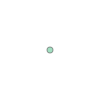

In [ ]:
gdf_results['geometry'][0]

In [ ]:
oil = list(gdf_results['Producto'].unique())
oil

['GASOLINA EXTRA OXIGENADA', 'BIODIESEL EXTRA', 'GASOLINA CORRIENTE OXIGENADA']

In [ ]:
gdf_results_2 = gdf_results[gdf_results['Producto']==oil[1]]
gdf_results_2.reset_index(inplace =  True)
gdf_results_2.drop(columns= 'index' , inplace = True)

In [ ]:
gdf_results_2.columns

Index(['Periodo', 'Mes', 'Codigo_departamento', 'Departamento',
       'Codigo_municipio', 'Municipio', 'Nombre_comercial', 'Bandera',
       'Direccion', 'Producto', 'Precio', 'Estado', 'Dir2', 'Full_Address',
       'Coords', 'LAT', 'LNG', 'POINT', 'SOURCE', 'DISTANCE', 'geometry'],
      dtype='object')

In [ ]:
gdf_results_2['Precio'].min()

8689

In [ ]:
gdf_results_2['Precio'].max()

9580

# Create Map

In [ ]:
def marker_rest(df,mapa,unit,oil,icono):

    df = df[df['Producto']==oil]
    df = df.reset_index()
    df = df.drop(columns = 'index')

    for i in range(len(df)):

        if df['Precio'][i]==df['Precio'].min():

            html =  f"""<b>MARCA:</b> {df.Bandera[i]} <br>
                    <b>NAME:</b> {df.Nombre_comercial[i]} <br>
                    <b>PRODUCTO:</b> {df.Producto[i]} <br>
                    <b>PRECIO:</b> {df.Precio[i]} <br>
                    <b>DISTANCE:</b> {round(df.DISTANCE[i],2)}<br>
                    <b>DIRECCION:</b> {df.Direccion[i]}<br>
                    <b>UNIT:</b> {unit}<br>"""
            iframe = folium.IFrame(html,figsize=(6, 3))
            popup = folium.Popup(iframe)




            folium.Marker(location=[float(df['LAT'][i]),float(df['LNG'][i])],
                               icon=folium.Icon(color='darkgreen', icon_color='white',
                               icon=icono, prefix='glyphicon'),
                               popup = popup).add_to(mapa)

        elif df['Precio'][i]==df['Precio'].max():

            html =  f"""<b>MARCA:</b> {df.Bandera[i]} <br>
                    <b>NAME:</b> {df.Nombre_comercial[i]} <br>
                    <b>PRODUCTO:</b> {df.Producto[i]} <br>
                    <b>PRECIO:</b> {df.Precio[i]} <br>
                    <b>DISTANCE:</b> {round(df.DISTANCE[i],2)}<br>
                    <b>DIRECCION:</b> {df.Direccion[i]}<br>
                    <b>UNIT:</b> {unit}<br>"""
            iframe = folium.IFrame(html,figsize=(6, 3))
            popup = folium.Popup(iframe)



            folium.Marker(location=[float(df['LAT'][i]),float(df['LNG'][i])],
                               icon=folium.Icon(color='darkred', icon_color='white',
                               icon=icono, prefix='glyphicon'),
                               popup =popup).add_to(mapa)
        else :
            html =  f"""<b>MARCA:</b> {df.Bandera[i]} <br>
                    <b>NAME:</b> {df.Nombre_comercial[i]} <br>
                    <b>PRODUCTO:</b> {df.Producto[i]} <br>
                    <b>PRECIO:</b> {df.Precio[i]} <br>
                    <b>DISTANCE:</b> {round(df.DISTANCE[i],2)}<br>
                    <b>DIRECCION:</b> {df.Direccion[i]}<br>
                    <b>UNIT:</b> {unit}<br>"""
            iframe = folium.IFrame(html,figsize=(6, 3))
            popup = folium.Popup(iframe)



            folium.Marker(location=[float(df['LAT'][i]),float(df['LNG'][i])],
                               icon=folium.Icon(color='orange', icon_color='white',
                               icon=icono, prefix='glyphicon'),
                               popup =popup).add_to(mapa)

    return

# Show Map

In [ ]:
m = folium.Map([geo_source[0],geo_source[1]], zoom_start= 15)

folium.Circle(

    radius = int(radio)*1000,
    location = [geo_source[0],geo_source[1]],
    color = 'green',
    fill = 'green'

).add_to(m)

folium.Marker(

            location = [geo_source[0],geo_source[1]],
            icon =  folium.Icon(color='black',icon_color='white',
            icon = "home",prefix = 'glyphicon'),
            popup = "<b>Centroid</b>").add_to(m)

marker_rest(gdf_results_2,m,unit,oil[1],'usd')

m

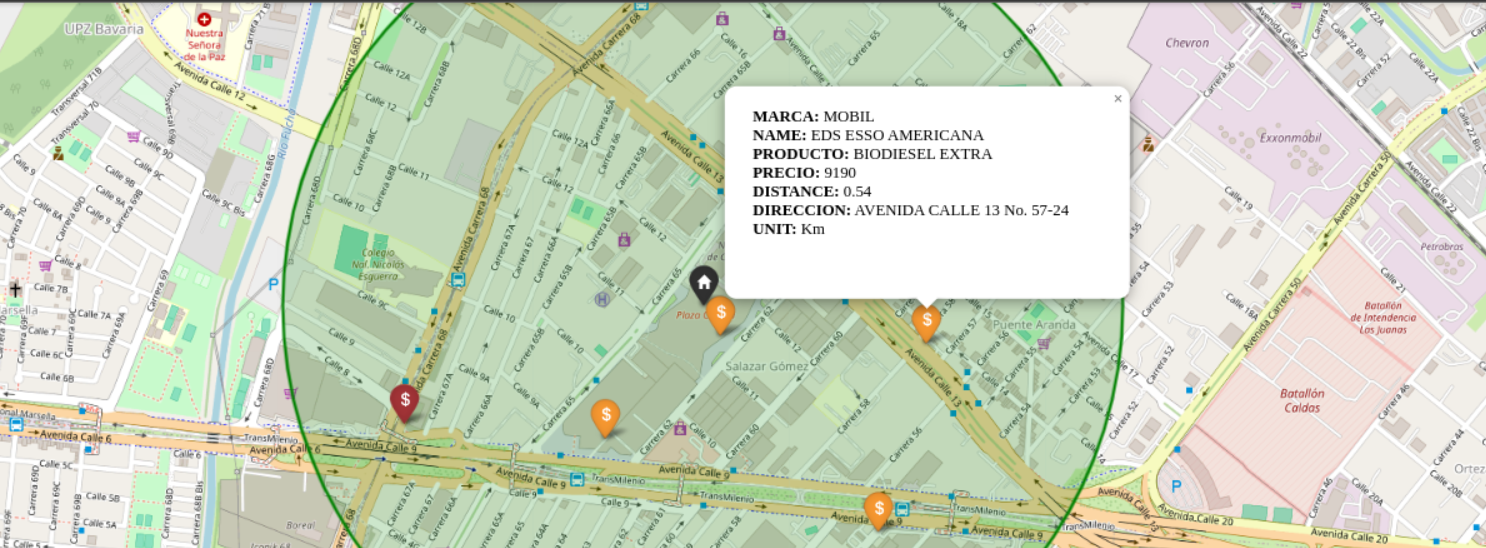